In [1]:
!pip3 install http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl torchvision
  

torch-0.4.0-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.
You are using pip version 8.1.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

%matplotlib inline
ROZMIAR_OKNA=35

import random
import ntpath
import cv2

import os
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import cv2
import numpy as np
import matplotlib.pyplot as plt

#from google.colab import files
from scipy.misc import imsave



In [5]:
def normalize_img(imgs, imgs_std, imgs_mean):
  #imgs_normalized = np.empty(imgs.shape)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (np.max(imgs_normalized[i])-np.min(imgs_normalized[i])))
    return imgs_normalized
  

In [6]:
def generuj_dane_uczace(img_dir = 'data_pre/images', manual_dir = 'data_pre/manual1', output_dir = 'data', rozmiar_okna=ROZMIAR_OKNA, ile=500):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    files = [file for file in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, file))]
    
    z = np.empty( (ile*len(files), rozmiar_okna, rozmiar_okna), dtype=np.float32)
    bez = np.empty( (ile*len(files), rozmiar_okna, rozmiar_okna), dtype=np.float32)
    zidx = 0
    bezidx = 0
    for file in files:
        if file.lower().endswith(".jpg"):
            img_path = img_dir + '/' + file
            img_ref_path = manual_dir + '/' + file[:-len('.jpg')] + '.tif'

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_ref = cv2.imread(img_ref_path, cv2.IMREAD_GRAYSCALE)
            dir, filename = ntpath.split(img_path)
            print(filename)
              # Wyliczenie srodka obrazu (zalozenie, ze okno jest kwadratowe)
            ramka = rozmiar_okna // 2

            vessels = set()
            no_vessels = set()
            while (len(vessels)<ile or len(no_vessels) < ile):
                x = random.randint(ramka+1, img.shape[0]-ramka-1)
                y = random.randint(ramka+1, img.shape[1]-ramka-1)
                while (x,y) in vessels or (x,y) in no_vessels:
                    x = random.randint(ramka+1, img.shape[0]-ramka-1)
                    y = random.randint(ramka+1, img.shape[1]-ramka-1)

                res = 1 if img_ref[x, y] > 120 else 0

                wycinek = img[x-ramka:x+ramka+1, y-ramka : y+ramka+1]
                if res and len(vessels)<ile:
                    vessels.add((x,y))
                    z[zidx] = wycinek
                    zidx += 1
                elif len(no_vessels) < ile:
                    no_vessels.add((x,y))
                    bez[bezidx] = wycinek
                    bezidx += 1
    return (z,bez)

In [7]:
class ImageRandomFragmentDataset(Dataset):

    def __init__(self, z, bez, transform=None):
        """
        Args:
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.z = z
        self.bez = bez
        self.transform = transform

    def __len__(self):
        return len(z) + len(bez) -2

    def __getitem__(self, idx):
        if idx % 2 == 0:
            wycinek = z[idx//2+1]
              res=1
        else:
            wycinek = bez[idx//2]
            res=0
        res = torch.tensor(float(res))
        #wycinek = normalize_img(wycinek)
        wycinek = torch.from_numpy(wycinek).unsqueeze(0)
        sample = {'img': wycinek, 'res': res}


        return sample


In [3]:
!ls

all.zip  datalab


In [8]:
!rm -r data_pre
!mkdir data_pre
!wget --header 'Host: www5.cs.fau.de' --user-agent 'Mozilla/5.0 (X11; Linux x86_64; rv:60.0) Gecko/20100101 Firefox/60.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://www5.cs.fau.de/research/data/fundus-images/' --header 'Cookie: fe_typo_user=dd3d9dde7713d395668218d7739d8df8' --header 'DNT: 1' --header 'Upgrade-Insecure-Requests: 1' 'https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/all.zip' --output-document 'all.zip'
!unzip all.zip -d data_pre/

rm: cannot remove 'data_pre': No such file or directory
--2018-05-09 09:17:55--  https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/all.zip
Resolving www5.cs.fau.de (www5.cs.fau.de)... 131.188.35.225
Connecting to www5.cs.fau.de (www5.cs.fau.de)|131.188.35.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76317613 (73M) [application/zip]
Saving to: ‘all.zip’

all.zip             100%[===================>]  72.78M  33.4MB/s    in 2.2s    

2018-05-09 09:17:57 (33.4 MB/s) - ‘all.zip’ saved [76317613/76317613]

Archive:  all.zip
   creating: data_pre/images/
  inflating: data_pre/images/01_dr.JPG  
  inflating: data_pre/images/01_g.jpg  
  inflating: data_pre/images/01_h.jpg  
  inflating: data_pre/images/02_dr.JPG  
  inflating: data_pre/images/02_g.jpg  
  inflating: data_pre/images/02_h.jpg  
  inflating: data_pre/images/03_dr.JPG  
  inflating: data_pre/images/03_g.jpg  
  inflating: data_pre/images/03_h.jpg  
  inflating: data_pre/images/04_d

In [9]:
z, bez = generuj_dane_uczace(ile=800)

10_h.jpg
02_g.jpg
02_dr.JPG
12_g.jpg
11_h.jpg
08_h.jpg
08_g.jpg
13_g.jpg
03_g.jpg
09_h.jpg
11_dr.JPG
13_h.jpg
10_dr.JPG
15_dr.JPG
07_g.jpg
10_g.jpg
09_g.jpg
07_h.jpg
11_g.jpg
02_h.jpg
14_dr.JPG
12_dr.JPG
13_dr.JPG
01_g.jpg
04_dr.JPG
14_h.jpg
04_g.jpg
15_h.jpg
05_dr.JPG
06_h.jpg
03_dr.JPG
05_h.jpg
05_g.jpg
09_dr.JPG
14_g.jpg
12_h.jpg
01_dr.JPG
07_dr.JPG
06_dr.JPG
08_dr.JPG
06_g.jpg
04_h.jpg
03_h.jpg
01_h.jpg
15_g.jpg


In [10]:
razem = np.concatenate((z,bez),axis=0)
imgs_std = np.std(razem)
imgs_mean = np.mean(razem)
z = normalize_img(z, imgs_std, imgs_mean)
bez = normalize_img(bez, imgs_std, imgs_mean)

In [12]:
print(imgs_std)
print(imgs_mean)

32.455765
87.11165


In [11]:
# -*- coding: utf-8 -*-



import torch.nn.functional as F
# Hyper Parameters
batch_size = 300

learn_dataset = ImageRandomFragmentDataset(z, bez)

# learn_dataset = dsets.ImageFolder(root='data/train',
#                                            transform=data_transform)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=learn_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)


# CNN Model (2 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(2304, 1024)
        self.fc2 = nn.Linear(1024, 2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.fc2(out)
        return out
        
cnn = CNN()

cnn.cuda()


CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=Tr

In [12]:
num_epochs = 50
learning_rate = 0.005

cnn.train()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(cnn.parameters(), lr=learning_rate, momentum=0.9)

In [16]:
# Train the Model
for epoch in range(num_epochs):
    for i, sample in enumerate(train_loader):
        images = sample['img'].to("cuda:0", dtype=torch.float32)
        labels = sample['res'].to("cuda:0", dtype=torch.long)\
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if i %1==0:
          print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
               %(epoch+1, num_epochs, i+1, len(learn_dataset)//batch_size, loss.data[0]))

# Save the Trained Model
torch.save(cnn.state_dict(), 'cnn.pkl')



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


Epoch [1/50], Iter [1/239] Loss: 0.6860
Epoch [1/50], Iter [2/239] Loss: 0.6748
Epoch [1/50], Iter [3/239] Loss: 0.6439
Epoch [1/50], Iter [4/239] Loss: 0.6278
Epoch [1/50], Iter [5/239] Loss: 0.5729
Epoch [1/50], Iter [6/239] Loss: 0.5573
Epoch [1/50], Iter [7/239] Loss: 0.5162
Epoch [1/50], Iter [8/239] Loss: 0.5255
Epoch [1/50], Iter [9/239] Loss: 0.4988
Epoch [1/50], Iter [10/239] Loss: 0.5096
Epoch [1/50], Iter [11/239] Loss: 0.4318
Epoch [1/50], Iter [12/239] Loss: 0.4407
Epoch [1/50], Iter [13/239] Loss: 0.3810
Epoch [1/50], Iter [14/239] Loss: 0.4274
Epoch [1/50], Iter [15/239] Loss: 0.4149
Epoch [1/50], Iter [16/239] Loss: 0.3953
Epoch [1/50], Iter [17/239] Loss: 0.4154
Epoch [1/50], Iter [18/239] Loss: 0.3613
Epoch [1/50], Iter [19/239] Loss: 0.3927
Epoch [1/50], Iter [20/239] Loss: 0.3566
Epoch [1/50], Iter [21/239] Loss: 0.3579
Epoch [1/50], Iter [22/239] Loss: 0.4354
Epoch [1/50], Iter [23/239] Loss: 0.3295
Epoch [1/50], Iter [24/239] Loss: 0.3745
Epoch [1/50], Iter [25/23

Epoch [2/50], Iter [113/239] Loss: 0.2447
Epoch [2/50], Iter [114/239] Loss: 0.3110
Epoch [2/50], Iter [115/239] Loss: 0.2589
Epoch [2/50], Iter [116/239] Loss: 0.2862
Epoch [2/50], Iter [117/239] Loss: 0.2420
Epoch [2/50], Iter [118/239] Loss: 0.2636
Epoch [2/50], Iter [119/239] Loss: 0.2690
Epoch [2/50], Iter [120/239] Loss: 0.2318
Epoch [2/50], Iter [121/239] Loss: 0.2648
Epoch [2/50], Iter [122/239] Loss: 0.2959
Epoch [2/50], Iter [123/239] Loss: 0.2843
Epoch [2/50], Iter [124/239] Loss: 0.2602
Epoch [2/50], Iter [125/239] Loss: 0.2680
Epoch [2/50], Iter [126/239] Loss: 0.2956
Epoch [2/50], Iter [127/239] Loss: 0.2984
Epoch [2/50], Iter [128/239] Loss: 0.2626
Epoch [2/50], Iter [129/239] Loss: 0.2614
Epoch [2/50], Iter [130/239] Loss: 0.2562
Epoch [2/50], Iter [131/239] Loss: 0.2825
Epoch [2/50], Iter [132/239] Loss: 0.2365
Epoch [2/50], Iter [133/239] Loss: 0.2386
Epoch [2/50], Iter [134/239] Loss: 0.2644
Epoch [2/50], Iter [135/239] Loss: 0.2472
Epoch [2/50], Iter [136/239] Loss:

Epoch [3/50], Iter [221/239] Loss: 0.3277
Epoch [3/50], Iter [222/239] Loss: 0.2499
Epoch [3/50], Iter [223/239] Loss: 0.3082
Epoch [3/50], Iter [224/239] Loss: 0.2684
Epoch [3/50], Iter [225/239] Loss: 0.2562
Epoch [3/50], Iter [226/239] Loss: 0.2316
Epoch [3/50], Iter [227/239] Loss: 0.2460
Epoch [3/50], Iter [228/239] Loss: 0.2246
Epoch [3/50], Iter [229/239] Loss: 0.2705
Epoch [3/50], Iter [230/239] Loss: 0.2537
Epoch [3/50], Iter [231/239] Loss: 0.2357
Epoch [3/50], Iter [232/239] Loss: 0.2758
Epoch [3/50], Iter [233/239] Loss: 0.2115
Epoch [3/50], Iter [234/239] Loss: 0.2585
Epoch [3/50], Iter [235/239] Loss: 0.2611
Epoch [3/50], Iter [236/239] Loss: 0.2511
Epoch [3/50], Iter [237/239] Loss: 0.2513
Epoch [3/50], Iter [238/239] Loss: 0.2395
Epoch [3/50], Iter [239/239] Loss: 0.2100
Epoch [3/50], Iter [240/239] Loss: 0.2986
Epoch [4/50], Iter [1/239] Loss: 0.2494
Epoch [4/50], Iter [2/239] Loss: 0.2504
Epoch [4/50], Iter [3/239] Loss: 0.2064
Epoch [4/50], Iter [4/239] Loss: 0.2662


Epoch [5/50], Iter [91/239] Loss: 0.2373
Epoch [5/50], Iter [92/239] Loss: 0.2732
Epoch [5/50], Iter [93/239] Loss: 0.2788
Epoch [5/50], Iter [94/239] Loss: 0.2808
Epoch [5/50], Iter [95/239] Loss: 0.2468
Epoch [5/50], Iter [96/239] Loss: 0.2263
Epoch [5/50], Iter [97/239] Loss: 0.1979
Epoch [5/50], Iter [98/239] Loss: 0.2730
Epoch [5/50], Iter [99/239] Loss: 0.1580
Epoch [5/50], Iter [100/239] Loss: 0.2154
Epoch [5/50], Iter [101/239] Loss: 0.2178
Epoch [5/50], Iter [102/239] Loss: 0.2380
Epoch [5/50], Iter [103/239] Loss: 0.2543
Epoch [5/50], Iter [104/239] Loss: 0.2671
Epoch [5/50], Iter [105/239] Loss: 0.2391
Epoch [5/50], Iter [106/239] Loss: 0.2558
Epoch [5/50], Iter [107/239] Loss: 0.1980
Epoch [5/50], Iter [108/239] Loss: 0.2139
Epoch [5/50], Iter [109/239] Loss: 0.2783
Epoch [5/50], Iter [110/239] Loss: 0.2327
Epoch [5/50], Iter [111/239] Loss: 0.2309
Epoch [5/50], Iter [112/239] Loss: 0.2167
Epoch [5/50], Iter [113/239] Loss: 0.2127
Epoch [5/50], Iter [114/239] Loss: 0.2462
E

Epoch [6/50], Iter [200/239] Loss: 0.1815
Epoch [6/50], Iter [201/239] Loss: 0.2203
Epoch [6/50], Iter [202/239] Loss: 0.2736
Epoch [6/50], Iter [203/239] Loss: 0.2974
Epoch [6/50], Iter [204/239] Loss: 0.2964
Epoch [6/50], Iter [205/239] Loss: 0.2515
Epoch [6/50], Iter [206/239] Loss: 0.2584
Epoch [6/50], Iter [207/239] Loss: 0.1981
Epoch [6/50], Iter [208/239] Loss: 0.2026
Epoch [6/50], Iter [209/239] Loss: 0.2331
Epoch [6/50], Iter [210/239] Loss: 0.2037
Epoch [6/50], Iter [211/239] Loss: 0.2775
Epoch [6/50], Iter [212/239] Loss: 0.2289
Epoch [6/50], Iter [213/239] Loss: 0.2519
Epoch [6/50], Iter [214/239] Loss: 0.2109
Epoch [6/50], Iter [215/239] Loss: 0.2114
Epoch [6/50], Iter [216/239] Loss: 0.2399
Epoch [6/50], Iter [217/239] Loss: 0.2655
Epoch [6/50], Iter [218/239] Loss: 0.1835
Epoch [6/50], Iter [219/239] Loss: 0.2370
Epoch [6/50], Iter [220/239] Loss: 0.2497
Epoch [6/50], Iter [221/239] Loss: 0.2471
Epoch [6/50], Iter [222/239] Loss: 0.2427
Epoch [6/50], Iter [223/239] Loss:

Epoch [8/50], Iter [70/239] Loss: 0.2421
Epoch [8/50], Iter [71/239] Loss: 0.2300
Epoch [8/50], Iter [72/239] Loss: 0.2152
Epoch [8/50], Iter [73/239] Loss: 0.1924
Epoch [8/50], Iter [74/239] Loss: 0.1982
Epoch [8/50], Iter [75/239] Loss: 0.2728
Epoch [8/50], Iter [76/239] Loss: 0.2213
Epoch [8/50], Iter [77/239] Loss: 0.2154
Epoch [8/50], Iter [78/239] Loss: 0.2536
Epoch [8/50], Iter [79/239] Loss: 0.1684
Epoch [8/50], Iter [80/239] Loss: 0.2644
Epoch [8/50], Iter [81/239] Loss: 0.1980
Epoch [8/50], Iter [82/239] Loss: 0.2273
Epoch [8/50], Iter [83/239] Loss: 0.2430
Epoch [8/50], Iter [84/239] Loss: 0.2473
Epoch [8/50], Iter [85/239] Loss: 0.2263
Epoch [8/50], Iter [86/239] Loss: 0.2338
Epoch [8/50], Iter [87/239] Loss: 0.2175
Epoch [8/50], Iter [88/239] Loss: 0.1746
Epoch [8/50], Iter [89/239] Loss: 0.2196
Epoch [8/50], Iter [90/239] Loss: 0.2075
Epoch [8/50], Iter [91/239] Loss: 0.2688
Epoch [8/50], Iter [92/239] Loss: 0.1974
Epoch [8/50], Iter [93/239] Loss: 0.2131
Epoch [8/50], It

Epoch [9/50], Iter [179/239] Loss: 0.2004
Epoch [9/50], Iter [180/239] Loss: 0.1878
Epoch [9/50], Iter [181/239] Loss: 0.1898
Epoch [9/50], Iter [182/239] Loss: 0.2540
Epoch [9/50], Iter [183/239] Loss: 0.2250
Epoch [9/50], Iter [184/239] Loss: 0.2378
Epoch [9/50], Iter [185/239] Loss: 0.2039
Epoch [9/50], Iter [186/239] Loss: 0.2211
Epoch [9/50], Iter [187/239] Loss: 0.2231
Epoch [9/50], Iter [188/239] Loss: 0.2117
Epoch [9/50], Iter [189/239] Loss: 0.2627
Epoch [9/50], Iter [190/239] Loss: 0.2381
Epoch [9/50], Iter [191/239] Loss: 0.2579
Epoch [9/50], Iter [192/239] Loss: 0.2596
Epoch [9/50], Iter [193/239] Loss: 0.2283
Epoch [9/50], Iter [194/239] Loss: 0.2226
Epoch [9/50], Iter [195/239] Loss: 0.2266
Epoch [9/50], Iter [196/239] Loss: 0.2039
Epoch [9/50], Iter [197/239] Loss: 0.2119
Epoch [9/50], Iter [198/239] Loss: 0.2494
Epoch [9/50], Iter [199/239] Loss: 0.1790
Epoch [9/50], Iter [200/239] Loss: 0.2837
Epoch [9/50], Iter [201/239] Loss: 0.2188
Epoch [9/50], Iter [202/239] Loss:

Epoch [11/50], Iter [48/239] Loss: 0.2025
Epoch [11/50], Iter [49/239] Loss: 0.1632
Epoch [11/50], Iter [50/239] Loss: 0.2268
Epoch [11/50], Iter [51/239] Loss: 0.2276
Epoch [11/50], Iter [52/239] Loss: 0.2402
Epoch [11/50], Iter [53/239] Loss: 0.2272
Epoch [11/50], Iter [54/239] Loss: 0.1885
Epoch [11/50], Iter [55/239] Loss: 0.2062
Epoch [11/50], Iter [56/239] Loss: 0.2067
Epoch [11/50], Iter [57/239] Loss: 0.2221
Epoch [11/50], Iter [58/239] Loss: 0.2510
Epoch [11/50], Iter [59/239] Loss: 0.1838
Epoch [11/50], Iter [60/239] Loss: 0.2352
Epoch [11/50], Iter [61/239] Loss: 0.2347
Epoch [11/50], Iter [62/239] Loss: 0.1939
Epoch [11/50], Iter [63/239] Loss: 0.2418
Epoch [11/50], Iter [64/239] Loss: 0.2612
Epoch [11/50], Iter [65/239] Loss: 0.1766
Epoch [11/50], Iter [66/239] Loss: 0.2492
Epoch [11/50], Iter [67/239] Loss: 0.2120
Epoch [11/50], Iter [68/239] Loss: 0.1748
Epoch [11/50], Iter [69/239] Loss: 0.2343
Epoch [11/50], Iter [70/239] Loss: 0.2090
Epoch [11/50], Iter [71/239] Loss:

Epoch [12/50], Iter [158/239] Loss: 0.1816
Epoch [12/50], Iter [159/239] Loss: 0.1939
Epoch [12/50], Iter [160/239] Loss: 0.2015
Epoch [12/50], Iter [161/239] Loss: 0.2564
Epoch [12/50], Iter [162/239] Loss: 0.2489
Epoch [12/50], Iter [163/239] Loss: 0.2375
Epoch [12/50], Iter [164/239] Loss: 0.2182
Epoch [12/50], Iter [165/239] Loss: 0.2036
Epoch [12/50], Iter [166/239] Loss: 0.1712
Epoch [12/50], Iter [167/239] Loss: 0.2757
Epoch [12/50], Iter [168/239] Loss: 0.1987
Epoch [12/50], Iter [169/239] Loss: 0.2202
Epoch [12/50], Iter [170/239] Loss: 0.2367
Epoch [12/50], Iter [171/239] Loss: 0.2959
Epoch [12/50], Iter [172/239] Loss: 0.2299
Epoch [12/50], Iter [173/239] Loss: 0.2026
Epoch [12/50], Iter [174/239] Loss: 0.2523
Epoch [12/50], Iter [175/239] Loss: 0.1994
Epoch [12/50], Iter [176/239] Loss: 0.2547
Epoch [12/50], Iter [177/239] Loss: 0.2261
Epoch [12/50], Iter [178/239] Loss: 0.2178
Epoch [12/50], Iter [179/239] Loss: 0.2118
Epoch [12/50], Iter [180/239] Loss: 0.1755
Epoch [12/5

Epoch [14/50], Iter [26/239] Loss: 0.1890
Epoch [14/50], Iter [27/239] Loss: 0.1735
Epoch [14/50], Iter [28/239] Loss: 0.2265
Epoch [14/50], Iter [29/239] Loss: 0.2698
Epoch [14/50], Iter [30/239] Loss: 0.2319
Epoch [14/50], Iter [31/239] Loss: 0.2607
Epoch [14/50], Iter [32/239] Loss: 0.2398
Epoch [14/50], Iter [33/239] Loss: 0.1999
Epoch [14/50], Iter [34/239] Loss: 0.2612
Epoch [14/50], Iter [35/239] Loss: 0.2295
Epoch [14/50], Iter [36/239] Loss: 0.2285
Epoch [14/50], Iter [37/239] Loss: 0.2171
Epoch [14/50], Iter [38/239] Loss: 0.1896
Epoch [14/50], Iter [39/239] Loss: 0.1845
Epoch [14/50], Iter [40/239] Loss: 0.1941
Epoch [14/50], Iter [41/239] Loss: 0.2103
Epoch [14/50], Iter [42/239] Loss: 0.2857
Epoch [14/50], Iter [43/239] Loss: 0.1954
Epoch [14/50], Iter [44/239] Loss: 0.1875
Epoch [14/50], Iter [45/239] Loss: 0.1735
Epoch [14/50], Iter [46/239] Loss: 0.1795
Epoch [14/50], Iter [47/239] Loss: 0.2477
Epoch [14/50], Iter [48/239] Loss: 0.2243
Epoch [14/50], Iter [49/239] Loss:

Epoch [15/50], Iter [136/239] Loss: 0.2204
Epoch [15/50], Iter [137/239] Loss: 0.2063
Epoch [15/50], Iter [138/239] Loss: 0.2091
Epoch [15/50], Iter [139/239] Loss: 0.2527
Epoch [15/50], Iter [140/239] Loss: 0.1482
Epoch [15/50], Iter [141/239] Loss: 0.1853
Epoch [15/50], Iter [142/239] Loss: 0.2363
Epoch [15/50], Iter [143/239] Loss: 0.1741
Epoch [15/50], Iter [144/239] Loss: 0.2241
Epoch [15/50], Iter [145/239] Loss: 0.2896
Epoch [15/50], Iter [146/239] Loss: 0.2848
Epoch [15/50], Iter [147/239] Loss: 0.2765
Epoch [15/50], Iter [148/239] Loss: 0.2003
Epoch [15/50], Iter [149/239] Loss: 0.2150
Epoch [15/50], Iter [150/239] Loss: 0.2290
Epoch [15/50], Iter [151/239] Loss: 0.2505
Epoch [15/50], Iter [152/239] Loss: 0.1488
Epoch [15/50], Iter [153/239] Loss: 0.3372
Epoch [15/50], Iter [154/239] Loss: 0.2387
Epoch [15/50], Iter [155/239] Loss: 0.2956
Epoch [15/50], Iter [156/239] Loss: 0.2051
Epoch [15/50], Iter [157/239] Loss: 0.1976
Epoch [15/50], Iter [158/239] Loss: 0.2139
Epoch [15/5

Epoch [17/50], Iter [3/239] Loss: 0.1824
Epoch [17/50], Iter [4/239] Loss: 0.1774
Epoch [17/50], Iter [5/239] Loss: 0.1464
Epoch [17/50], Iter [6/239] Loss: 0.1638
Epoch [17/50], Iter [7/239] Loss: 0.2155
Epoch [17/50], Iter [8/239] Loss: 0.2081
Epoch [17/50], Iter [9/239] Loss: 0.2020
Epoch [17/50], Iter [10/239] Loss: 0.1991
Epoch [17/50], Iter [11/239] Loss: 0.2110
Epoch [17/50], Iter [12/239] Loss: 0.2031
Epoch [17/50], Iter [13/239] Loss: 0.1750
Epoch [17/50], Iter [14/239] Loss: 0.2337
Epoch [17/50], Iter [15/239] Loss: 0.1524
Epoch [17/50], Iter [16/239] Loss: 0.2285
Epoch [17/50], Iter [17/239] Loss: 0.2176
Epoch [17/50], Iter [18/239] Loss: 0.2308
Epoch [17/50], Iter [19/239] Loss: 0.2005
Epoch [17/50], Iter [20/239] Loss: 0.2080
Epoch [17/50], Iter [21/239] Loss: 0.2374
Epoch [17/50], Iter [22/239] Loss: 0.1807
Epoch [17/50], Iter [23/239] Loss: 0.2050
Epoch [17/50], Iter [24/239] Loss: 0.2534
Epoch [17/50], Iter [25/239] Loss: 0.1984
Epoch [17/50], Iter [26/239] Loss: 0.2419

Epoch [18/50], Iter [113/239] Loss: 0.2386
Epoch [18/50], Iter [114/239] Loss: 0.2125
Epoch [18/50], Iter [115/239] Loss: 0.1370
Epoch [18/50], Iter [116/239] Loss: 0.1583
Epoch [18/50], Iter [117/239] Loss: 0.2117
Epoch [18/50], Iter [118/239] Loss: 0.1679
Epoch [18/50], Iter [119/239] Loss: 0.1856
Epoch [18/50], Iter [120/239] Loss: 0.2109
Epoch [18/50], Iter [121/239] Loss: 0.1904
Epoch [18/50], Iter [122/239] Loss: 0.1607
Epoch [18/50], Iter [123/239] Loss: 0.2101
Epoch [18/50], Iter [124/239] Loss: 0.2582
Epoch [18/50], Iter [125/239] Loss: 0.2572
Epoch [18/50], Iter [126/239] Loss: 0.2096
Epoch [18/50], Iter [127/239] Loss: 0.1900
Epoch [18/50], Iter [128/239] Loss: 0.1703
Epoch [18/50], Iter [129/239] Loss: 0.1984
Epoch [18/50], Iter [130/239] Loss: 0.1695
Epoch [18/50], Iter [131/239] Loss: 0.2682
Epoch [18/50], Iter [132/239] Loss: 0.2050
Epoch [18/50], Iter [133/239] Loss: 0.1955
Epoch [18/50], Iter [134/239] Loss: 0.1639
Epoch [18/50], Iter [135/239] Loss: 0.1814
Epoch [18/5

Epoch [19/50], Iter [221/239] Loss: 0.1758
Epoch [19/50], Iter [222/239] Loss: 0.2398
Epoch [19/50], Iter [223/239] Loss: 0.1994
Epoch [19/50], Iter [224/239] Loss: 0.1726
Epoch [19/50], Iter [225/239] Loss: 0.2294
Epoch [19/50], Iter [226/239] Loss: 0.2116
Epoch [19/50], Iter [227/239] Loss: 0.1933
Epoch [19/50], Iter [228/239] Loss: 0.1993
Epoch [19/50], Iter [229/239] Loss: 0.2280
Epoch [19/50], Iter [230/239] Loss: 0.2600
Epoch [19/50], Iter [231/239] Loss: 0.1787
Epoch [19/50], Iter [232/239] Loss: 0.2447
Epoch [19/50], Iter [233/239] Loss: 0.2144
Epoch [19/50], Iter [234/239] Loss: 0.2052
Epoch [19/50], Iter [235/239] Loss: 0.2171
Epoch [19/50], Iter [236/239] Loss: 0.1825
Epoch [19/50], Iter [237/239] Loss: 0.1945
Epoch [19/50], Iter [238/239] Loss: 0.2041
Epoch [19/50], Iter [239/239] Loss: 0.2253
Epoch [19/50], Iter [240/239] Loss: 0.1641
Epoch [20/50], Iter [1/239] Loss: 0.1809
Epoch [20/50], Iter [2/239] Loss: 0.1685
Epoch [20/50], Iter [3/239] Loss: 0.1776
Epoch [20/50], It

Epoch [21/50], Iter [90/239] Loss: 0.1644
Epoch [21/50], Iter [91/239] Loss: 0.2010
Epoch [21/50], Iter [92/239] Loss: 0.2535
Epoch [21/50], Iter [93/239] Loss: 0.1800
Epoch [21/50], Iter [94/239] Loss: 0.2182
Epoch [21/50], Iter [95/239] Loss: 0.2092
Epoch [21/50], Iter [96/239] Loss: 0.2229
Epoch [21/50], Iter [97/239] Loss: 0.1916
Epoch [21/50], Iter [98/239] Loss: 0.1813
Epoch [21/50], Iter [99/239] Loss: 0.1701
Epoch [21/50], Iter [100/239] Loss: 0.2240
Epoch [21/50], Iter [101/239] Loss: 0.2024
Epoch [21/50], Iter [102/239] Loss: 0.2021
Epoch [21/50], Iter [103/239] Loss: 0.1841
Epoch [21/50], Iter [104/239] Loss: 0.2686
Epoch [21/50], Iter [105/239] Loss: 0.2333
Epoch [21/50], Iter [106/239] Loss: 0.2772
Epoch [21/50], Iter [107/239] Loss: 0.1900
Epoch [21/50], Iter [108/239] Loss: 0.1948
Epoch [21/50], Iter [109/239] Loss: 0.2286
Epoch [21/50], Iter [110/239] Loss: 0.2221
Epoch [21/50], Iter [111/239] Loss: 0.1638
Epoch [21/50], Iter [112/239] Loss: 0.2096
Epoch [21/50], Iter [

Epoch [22/50], Iter [200/239] Loss: 0.1992
Epoch [22/50], Iter [201/239] Loss: 0.1613
Epoch [22/50], Iter [202/239] Loss: 0.2072
Epoch [22/50], Iter [203/239] Loss: 0.1957
Epoch [22/50], Iter [204/239] Loss: 0.2075
Epoch [22/50], Iter [205/239] Loss: 0.2380
Epoch [22/50], Iter [206/239] Loss: 0.1427
Epoch [22/50], Iter [207/239] Loss: 0.2015
Epoch [22/50], Iter [208/239] Loss: 0.2049
Epoch [22/50], Iter [209/239] Loss: 0.1695
Epoch [22/50], Iter [210/239] Loss: 0.1857
Epoch [22/50], Iter [211/239] Loss: 0.1877
Epoch [22/50], Iter [212/239] Loss: 0.2177
Epoch [22/50], Iter [213/239] Loss: 0.1319
Epoch [22/50], Iter [214/239] Loss: 0.1637
Epoch [22/50], Iter [215/239] Loss: 0.1683
Epoch [22/50], Iter [216/239] Loss: 0.1564
Epoch [22/50], Iter [217/239] Loss: 0.1970
Epoch [22/50], Iter [218/239] Loss: 0.1651
Epoch [22/50], Iter [219/239] Loss: 0.1433
Epoch [22/50], Iter [220/239] Loss: 0.2090
Epoch [22/50], Iter [221/239] Loss: 0.1654
Epoch [22/50], Iter [222/239] Loss: 0.2424
Epoch [22/5

Epoch [24/50], Iter [69/239] Loss: 0.2450
Epoch [24/50], Iter [70/239] Loss: 0.1967
Epoch [24/50], Iter [71/239] Loss: 0.2019
Epoch [24/50], Iter [72/239] Loss: 0.1734
Epoch [24/50], Iter [73/239] Loss: 0.2008
Epoch [24/50], Iter [74/239] Loss: 0.2017
Epoch [24/50], Iter [75/239] Loss: 0.1603
Epoch [24/50], Iter [76/239] Loss: 0.1872
Epoch [24/50], Iter [77/239] Loss: 0.1911
Epoch [24/50], Iter [78/239] Loss: 0.1688
Epoch [24/50], Iter [79/239] Loss: 0.1695
Epoch [24/50], Iter [80/239] Loss: 0.1548
Epoch [24/50], Iter [81/239] Loss: 0.1466
Epoch [24/50], Iter [82/239] Loss: 0.1630
Epoch [24/50], Iter [83/239] Loss: 0.2168
Epoch [24/50], Iter [84/239] Loss: 0.2068
Epoch [24/50], Iter [85/239] Loss: 0.1153
Epoch [24/50], Iter [86/239] Loss: 0.2363
Epoch [24/50], Iter [87/239] Loss: 0.1853
Epoch [24/50], Iter [88/239] Loss: 0.1741
Epoch [24/50], Iter [89/239] Loss: 0.2010
Epoch [24/50], Iter [90/239] Loss: 0.1619
Epoch [24/50], Iter [91/239] Loss: 0.2048
Epoch [24/50], Iter [92/239] Loss:

Epoch [25/50], Iter [179/239] Loss: 0.1545
Epoch [25/50], Iter [180/239] Loss: 0.2494
Epoch [25/50], Iter [181/239] Loss: 0.1297
Epoch [25/50], Iter [182/239] Loss: 0.1659
Epoch [25/50], Iter [183/239] Loss: 0.2354
Epoch [25/50], Iter [184/239] Loss: 0.1767
Epoch [25/50], Iter [185/239] Loss: 0.1530
Epoch [25/50], Iter [186/239] Loss: 0.1619
Epoch [25/50], Iter [187/239] Loss: 0.2798
Epoch [25/50], Iter [188/239] Loss: 0.1849
Epoch [25/50], Iter [189/239] Loss: 0.1729
Epoch [25/50], Iter [190/239] Loss: 0.1642
Epoch [25/50], Iter [191/239] Loss: 0.1392
Epoch [25/50], Iter [192/239] Loss: 0.1676
Epoch [25/50], Iter [193/239] Loss: 0.1625
Epoch [25/50], Iter [194/239] Loss: 0.1614
Epoch [25/50], Iter [195/239] Loss: 0.2237
Epoch [25/50], Iter [196/239] Loss: 0.2119
Epoch [25/50], Iter [197/239] Loss: 0.1475
Epoch [25/50], Iter [198/239] Loss: 0.1861
Epoch [25/50], Iter [199/239] Loss: 0.1914
Epoch [25/50], Iter [200/239] Loss: 0.1880
Epoch [25/50], Iter [201/239] Loss: 0.1806
Epoch [25/5

Epoch [27/50], Iter [48/239] Loss: 0.1573
Epoch [27/50], Iter [49/239] Loss: 0.1589
Epoch [27/50], Iter [50/239] Loss: 0.1447
Epoch [27/50], Iter [51/239] Loss: 0.1986
Epoch [27/50], Iter [52/239] Loss: 0.1743
Epoch [27/50], Iter [53/239] Loss: 0.1672
Epoch [27/50], Iter [54/239] Loss: 0.1823
Epoch [27/50], Iter [55/239] Loss: 0.1562
Epoch [27/50], Iter [56/239] Loss: 0.2143
Epoch [27/50], Iter [57/239] Loss: 0.1651
Epoch [27/50], Iter [58/239] Loss: 0.1908
Epoch [27/50], Iter [59/239] Loss: 0.1378
Epoch [27/50], Iter [60/239] Loss: 0.1987
Epoch [27/50], Iter [61/239] Loss: 0.1566
Epoch [27/50], Iter [62/239] Loss: 0.1844
Epoch [27/50], Iter [63/239] Loss: 0.1988
Epoch [27/50], Iter [64/239] Loss: 0.1857
Epoch [27/50], Iter [65/239] Loss: 0.1581
Epoch [27/50], Iter [66/239] Loss: 0.1606
Epoch [27/50], Iter [67/239] Loss: 0.1708
Epoch [27/50], Iter [68/239] Loss: 0.1987
Epoch [27/50], Iter [69/239] Loss: 0.1870
Epoch [27/50], Iter [70/239] Loss: 0.1639
Epoch [27/50], Iter [71/239] Loss:

Epoch [28/50], Iter [157/239] Loss: 0.1927
Epoch [28/50], Iter [158/239] Loss: 0.1624
Epoch [28/50], Iter [159/239] Loss: 0.2072
Epoch [28/50], Iter [160/239] Loss: 0.1798
Epoch [28/50], Iter [161/239] Loss: 0.1351
Epoch [28/50], Iter [162/239] Loss: 0.1708
Epoch [28/50], Iter [163/239] Loss: 0.1668
Epoch [28/50], Iter [164/239] Loss: 0.1653
Epoch [28/50], Iter [165/239] Loss: 0.1652
Epoch [28/50], Iter [166/239] Loss: 0.1426
Epoch [28/50], Iter [167/239] Loss: 0.1205
Epoch [28/50], Iter [168/239] Loss: 0.1725
Epoch [28/50], Iter [169/239] Loss: 0.1420
Epoch [28/50], Iter [170/239] Loss: 0.1511
Epoch [28/50], Iter [171/239] Loss: 0.2017
Epoch [28/50], Iter [172/239] Loss: 0.1871
Epoch [28/50], Iter [173/239] Loss: 0.1721
Epoch [28/50], Iter [174/239] Loss: 0.2063
Epoch [28/50], Iter [175/239] Loss: 0.2340
Epoch [28/50], Iter [176/239] Loss: 0.1928
Epoch [28/50], Iter [177/239] Loss: 0.1642
Epoch [28/50], Iter [178/239] Loss: 0.1920
Epoch [28/50], Iter [179/239] Loss: 0.1995
Epoch [28/5

Epoch [30/50], Iter [27/239] Loss: 0.1624
Epoch [30/50], Iter [28/239] Loss: 0.1659
Epoch [30/50], Iter [29/239] Loss: 0.1544
Epoch [30/50], Iter [30/239] Loss: 0.1526
Epoch [30/50], Iter [31/239] Loss: 0.1669
Epoch [30/50], Iter [32/239] Loss: 0.1536
Epoch [30/50], Iter [33/239] Loss: 0.1877
Epoch [30/50], Iter [34/239] Loss: 0.1465
Epoch [30/50], Iter [35/239] Loss: 0.1711
Epoch [30/50], Iter [36/239] Loss: 0.1257
Epoch [30/50], Iter [37/239] Loss: 0.1194
Epoch [30/50], Iter [38/239] Loss: 0.1557
Epoch [30/50], Iter [39/239] Loss: 0.1312
Epoch [30/50], Iter [40/239] Loss: 0.1545
Epoch [30/50], Iter [41/239] Loss: 0.1572
Epoch [30/50], Iter [42/239] Loss: 0.1179
Epoch [30/50], Iter [43/239] Loss: 0.1387
Epoch [30/50], Iter [44/239] Loss: 0.1683
Epoch [30/50], Iter [45/239] Loss: 0.1750
Epoch [30/50], Iter [46/239] Loss: 0.1826
Epoch [30/50], Iter [47/239] Loss: 0.1418
Epoch [30/50], Iter [48/239] Loss: 0.1607
Epoch [30/50], Iter [49/239] Loss: 0.1688
Epoch [30/50], Iter [50/239] Loss:

Epoch [31/50], Iter [136/239] Loss: 0.1619
Epoch [31/50], Iter [137/239] Loss: 0.1191
Epoch [31/50], Iter [138/239] Loss: 0.2313
Epoch [31/50], Iter [139/239] Loss: 0.1558
Epoch [31/50], Iter [140/239] Loss: 0.2487
Epoch [31/50], Iter [141/239] Loss: 0.1583
Epoch [31/50], Iter [142/239] Loss: 0.1980
Epoch [31/50], Iter [143/239] Loss: 0.1543
Epoch [31/50], Iter [144/239] Loss: 0.1937
Epoch [31/50], Iter [145/239] Loss: 0.2339
Epoch [31/50], Iter [146/239] Loss: 0.1832
Epoch [31/50], Iter [147/239] Loss: 0.1326
Epoch [31/50], Iter [148/239] Loss: 0.1634
Epoch [31/50], Iter [149/239] Loss: 0.2049
Epoch [31/50], Iter [150/239] Loss: 0.1925
Epoch [31/50], Iter [151/239] Loss: 0.1602
Epoch [31/50], Iter [152/239] Loss: 0.1943
Epoch [31/50], Iter [153/239] Loss: 0.1374
Epoch [31/50], Iter [154/239] Loss: 0.1464
Epoch [31/50], Iter [155/239] Loss: 0.1342
Epoch [31/50], Iter [156/239] Loss: 0.1478
Epoch [31/50], Iter [157/239] Loss: 0.1824
Epoch [31/50], Iter [158/239] Loss: 0.1557
Epoch [31/5

Epoch [33/50], Iter [6/239] Loss: 0.1500
Epoch [33/50], Iter [7/239] Loss: 0.1699
Epoch [33/50], Iter [8/239] Loss: 0.1637
Epoch [33/50], Iter [9/239] Loss: 0.1442
Epoch [33/50], Iter [10/239] Loss: 0.1341
Epoch [33/50], Iter [11/239] Loss: 0.1528
Epoch [33/50], Iter [12/239] Loss: 0.1489
Epoch [33/50], Iter [13/239] Loss: 0.1090
Epoch [33/50], Iter [14/239] Loss: 0.1191
Epoch [33/50], Iter [15/239] Loss: 0.1150
Epoch [33/50], Iter [16/239] Loss: 0.1478
Epoch [33/50], Iter [17/239] Loss: 0.1443
Epoch [33/50], Iter [18/239] Loss: 0.1069
Epoch [33/50], Iter [19/239] Loss: 0.1014
Epoch [33/50], Iter [20/239] Loss: 0.1825
Epoch [33/50], Iter [21/239] Loss: 0.1555
Epoch [33/50], Iter [22/239] Loss: 0.1659
Epoch [33/50], Iter [23/239] Loss: 0.1831
Epoch [33/50], Iter [24/239] Loss: 0.2047
Epoch [33/50], Iter [25/239] Loss: 0.1882
Epoch [33/50], Iter [26/239] Loss: 0.1370
Epoch [33/50], Iter [27/239] Loss: 0.1518
Epoch [33/50], Iter [28/239] Loss: 0.1430
Epoch [33/50], Iter [29/239] Loss: 0.1

Epoch [34/50], Iter [115/239] Loss: 0.1759
Epoch [34/50], Iter [116/239] Loss: 0.1788
Epoch [34/50], Iter [117/239] Loss: 0.1682
Epoch [34/50], Iter [118/239] Loss: 0.1687
Epoch [34/50], Iter [119/239] Loss: 0.1815
Epoch [34/50], Iter [120/239] Loss: 0.1758
Epoch [34/50], Iter [121/239] Loss: 0.1658
Epoch [34/50], Iter [122/239] Loss: 0.2571
Epoch [34/50], Iter [123/239] Loss: 0.1823
Epoch [34/50], Iter [124/239] Loss: 0.1590
Epoch [34/50], Iter [125/239] Loss: 0.1895
Epoch [34/50], Iter [126/239] Loss: 0.1823
Epoch [34/50], Iter [127/239] Loss: 0.1508
Epoch [34/50], Iter [128/239] Loss: 0.1359
Epoch [34/50], Iter [129/239] Loss: 0.1356
Epoch [34/50], Iter [130/239] Loss: 0.1430
Epoch [34/50], Iter [131/239] Loss: 0.2011
Epoch [34/50], Iter [132/239] Loss: 0.1492
Epoch [34/50], Iter [133/239] Loss: 0.1815
Epoch [34/50], Iter [134/239] Loss: 0.1114
Epoch [34/50], Iter [135/239] Loss: 0.1695
Epoch [34/50], Iter [136/239] Loss: 0.1546
Epoch [34/50], Iter [137/239] Loss: 0.1251
Epoch [34/5

Epoch [35/50], Iter [225/239] Loss: 0.2160
Epoch [35/50], Iter [226/239] Loss: 0.1817
Epoch [35/50], Iter [227/239] Loss: 0.1379
Epoch [35/50], Iter [228/239] Loss: 0.1118
Epoch [35/50], Iter [229/239] Loss: 0.1601
Epoch [35/50], Iter [230/239] Loss: 0.1468
Epoch [35/50], Iter [231/239] Loss: 0.2004
Epoch [35/50], Iter [232/239] Loss: 0.1934
Epoch [35/50], Iter [233/239] Loss: 0.1755
Epoch [35/50], Iter [234/239] Loss: 0.1706
Epoch [35/50], Iter [235/239] Loss: 0.1800
Epoch [35/50], Iter [236/239] Loss: 0.2035
Epoch [35/50], Iter [237/239] Loss: 0.1358
Epoch [35/50], Iter [238/239] Loss: 0.1580
Epoch [35/50], Iter [239/239] Loss: 0.1531
Epoch [35/50], Iter [240/239] Loss: 0.1953
Epoch [36/50], Iter [1/239] Loss: 0.1563
Epoch [36/50], Iter [2/239] Loss: 0.1331
Epoch [36/50], Iter [3/239] Loss: 0.1543
Epoch [36/50], Iter [4/239] Loss: 0.1337
Epoch [36/50], Iter [5/239] Loss: 0.1546
Epoch [36/50], Iter [6/239] Loss: 0.1336
Epoch [36/50], Iter [7/239] Loss: 0.1113
Epoch [36/50], Iter [8/23

Epoch [37/50], Iter [94/239] Loss: 0.1479
Epoch [37/50], Iter [95/239] Loss: 0.1172
Epoch [37/50], Iter [96/239] Loss: 0.1415
Epoch [37/50], Iter [97/239] Loss: 0.1444
Epoch [37/50], Iter [98/239] Loss: 0.1314
Epoch [37/50], Iter [99/239] Loss: 0.1338
Epoch [37/50], Iter [100/239] Loss: 0.1311
Epoch [37/50], Iter [101/239] Loss: 0.1203
Epoch [37/50], Iter [102/239] Loss: 0.1269
Epoch [37/50], Iter [103/239] Loss: 0.0992
Epoch [37/50], Iter [104/239] Loss: 0.1335
Epoch [37/50], Iter [105/239] Loss: 0.1895
Epoch [37/50], Iter [106/239] Loss: 0.1775
Epoch [37/50], Iter [107/239] Loss: 0.1281
Epoch [37/50], Iter [108/239] Loss: 0.1132
Epoch [37/50], Iter [109/239] Loss: 0.1362
Epoch [37/50], Iter [110/239] Loss: 0.1836
Epoch [37/50], Iter [111/239] Loss: 0.1466
Epoch [37/50], Iter [112/239] Loss: 0.1431
Epoch [37/50], Iter [113/239] Loss: 0.1632
Epoch [37/50], Iter [114/239] Loss: 0.1639
Epoch [37/50], Iter [115/239] Loss: 0.1350
Epoch [37/50], Iter [116/239] Loss: 0.1372
Epoch [37/50], It

Epoch [38/50], Iter [203/239] Loss: 0.1326
Epoch [38/50], Iter [204/239] Loss: 0.1640
Epoch [38/50], Iter [205/239] Loss: 0.1512
Epoch [38/50], Iter [206/239] Loss: 0.1619
Epoch [38/50], Iter [207/239] Loss: 0.1190
Epoch [38/50], Iter [208/239] Loss: 0.1434
Epoch [38/50], Iter [209/239] Loss: 0.1087
Epoch [38/50], Iter [210/239] Loss: 0.1898
Epoch [38/50], Iter [211/239] Loss: 0.1384
Epoch [38/50], Iter [212/239] Loss: 0.1885
Epoch [38/50], Iter [213/239] Loss: 0.1503
Epoch [38/50], Iter [214/239] Loss: 0.1621
Epoch [38/50], Iter [215/239] Loss: 0.1294
Epoch [38/50], Iter [216/239] Loss: 0.1154
Epoch [38/50], Iter [217/239] Loss: 0.1750
Epoch [38/50], Iter [218/239] Loss: 0.1392
Epoch [38/50], Iter [219/239] Loss: 0.1502
Epoch [38/50], Iter [220/239] Loss: 0.1196
Epoch [38/50], Iter [221/239] Loss: 0.1095
Epoch [38/50], Iter [222/239] Loss: 0.1432
Epoch [38/50], Iter [223/239] Loss: 0.1513
Epoch [38/50], Iter [224/239] Loss: 0.1623
Epoch [38/50], Iter [225/239] Loss: 0.1834
Epoch [38/5

Epoch [40/50], Iter [68/239] Loss: 0.1698
Epoch [40/50], Iter [69/239] Loss: 0.1375
Epoch [40/50], Iter [70/239] Loss: 0.0973
Epoch [40/50], Iter [71/239] Loss: 0.1290
Epoch [40/50], Iter [72/239] Loss: 0.1719
Epoch [40/50], Iter [73/239] Loss: 0.1589
Epoch [40/50], Iter [74/239] Loss: 0.1496
Epoch [40/50], Iter [75/239] Loss: 0.1309
Epoch [40/50], Iter [76/239] Loss: 0.1760
Epoch [40/50], Iter [77/239] Loss: 0.1544
Epoch [40/50], Iter [78/239] Loss: 0.1484
Epoch [40/50], Iter [79/239] Loss: 0.1990
Epoch [40/50], Iter [80/239] Loss: 0.1271
Epoch [40/50], Iter [81/239] Loss: 0.1533
Epoch [40/50], Iter [82/239] Loss: 0.1808
Epoch [40/50], Iter [83/239] Loss: 0.2038
Epoch [40/50], Iter [84/239] Loss: 0.1300
Epoch [40/50], Iter [85/239] Loss: 0.1326
Epoch [40/50], Iter [86/239] Loss: 0.1077
Epoch [40/50], Iter [87/239] Loss: 0.1010
Epoch [40/50], Iter [88/239] Loss: 0.1236
Epoch [40/50], Iter [89/239] Loss: 0.0841
Epoch [40/50], Iter [90/239] Loss: 0.1251
Epoch [40/50], Iter [91/239] Loss:

Epoch [41/50], Iter [176/239] Loss: 0.1552
Epoch [41/50], Iter [177/239] Loss: 0.1166
Epoch [41/50], Iter [178/239] Loss: 0.1324
Epoch [41/50], Iter [179/239] Loss: 0.0976
Epoch [41/50], Iter [180/239] Loss: 0.1651
Epoch [41/50], Iter [181/239] Loss: 0.1084
Epoch [41/50], Iter [182/239] Loss: 0.1614
Epoch [41/50], Iter [183/239] Loss: 0.1165
Epoch [41/50], Iter [184/239] Loss: 0.1493
Epoch [41/50], Iter [185/239] Loss: 0.1220
Epoch [41/50], Iter [186/239] Loss: 0.1636
Epoch [41/50], Iter [187/239] Loss: 0.2085
Epoch [41/50], Iter [188/239] Loss: 0.1127
Epoch [41/50], Iter [189/239] Loss: 0.1503
Epoch [41/50], Iter [190/239] Loss: 0.1596
Epoch [41/50], Iter [191/239] Loss: 0.1450
Epoch [41/50], Iter [192/239] Loss: 0.1458
Epoch [41/50], Iter [193/239] Loss: 0.1466
Epoch [41/50], Iter [194/239] Loss: 0.1388
Epoch [41/50], Iter [195/239] Loss: 0.1277
Epoch [41/50], Iter [196/239] Loss: 0.1634
Epoch [41/50], Iter [197/239] Loss: 0.1553
Epoch [41/50], Iter [198/239] Loss: 0.1514
Epoch [41/5

Epoch [43/50], Iter [46/239] Loss: 0.1147
Epoch [43/50], Iter [47/239] Loss: 0.1304
Epoch [43/50], Iter [48/239] Loss: 0.0640
Epoch [43/50], Iter [49/239] Loss: 0.1375
Epoch [43/50], Iter [50/239] Loss: 0.1802
Epoch [43/50], Iter [51/239] Loss: 0.1487
Epoch [43/50], Iter [52/239] Loss: 0.0988
Epoch [43/50], Iter [53/239] Loss: 0.1520
Epoch [43/50], Iter [54/239] Loss: 0.1277
Epoch [43/50], Iter [55/239] Loss: 0.0934
Epoch [43/50], Iter [56/239] Loss: 0.1028
Epoch [43/50], Iter [57/239] Loss: 0.1583
Epoch [43/50], Iter [58/239] Loss: 0.1686
Epoch [43/50], Iter [59/239] Loss: 0.1046
Epoch [43/50], Iter [60/239] Loss: 0.1163
Epoch [43/50], Iter [61/239] Loss: 0.1191
Epoch [43/50], Iter [62/239] Loss: 0.2337
Epoch [43/50], Iter [63/239] Loss: 0.1335
Epoch [43/50], Iter [64/239] Loss: 0.1524
Epoch [43/50], Iter [65/239] Loss: 0.2063
Epoch [43/50], Iter [66/239] Loss: 0.1418
Epoch [43/50], Iter [67/239] Loss: 0.1070
Epoch [43/50], Iter [68/239] Loss: 0.1526
Epoch [43/50], Iter [69/239] Loss:

Epoch [44/50], Iter [154/239] Loss: 0.0811
Epoch [44/50], Iter [155/239] Loss: 0.1055
Epoch [44/50], Iter [156/239] Loss: 0.1153
Epoch [44/50], Iter [157/239] Loss: 0.1289
Epoch [44/50], Iter [158/239] Loss: 0.1109
Epoch [44/50], Iter [159/239] Loss: 0.1545
Epoch [44/50], Iter [160/239] Loss: 0.1594
Epoch [44/50], Iter [161/239] Loss: 0.1321
Epoch [44/50], Iter [162/239] Loss: 0.1934
Epoch [44/50], Iter [163/239] Loss: 0.1784
Epoch [44/50], Iter [164/239] Loss: 0.1562
Epoch [44/50], Iter [165/239] Loss: 0.1203
Epoch [44/50], Iter [166/239] Loss: 0.1406
Epoch [44/50], Iter [167/239] Loss: 0.1498
Epoch [44/50], Iter [168/239] Loss: 0.1148
Epoch [44/50], Iter [169/239] Loss: 0.1245
Epoch [44/50], Iter [170/239] Loss: 0.1456
Epoch [44/50], Iter [171/239] Loss: 0.1211
Epoch [44/50], Iter [172/239] Loss: 0.1565
Epoch [44/50], Iter [173/239] Loss: 0.1264
Epoch [44/50], Iter [174/239] Loss: 0.2186
Epoch [44/50], Iter [175/239] Loss: 0.0993
Epoch [44/50], Iter [176/239] Loss: 0.1595
Epoch [44/5

Epoch [46/50], Iter [24/239] Loss: 0.1131
Epoch [46/50], Iter [25/239] Loss: 0.1425
Epoch [46/50], Iter [26/239] Loss: 0.1425
Epoch [46/50], Iter [27/239] Loss: 0.0923
Epoch [46/50], Iter [28/239] Loss: 0.0779
Epoch [46/50], Iter [29/239] Loss: 0.1507
Epoch [46/50], Iter [30/239] Loss: 0.1212
Epoch [46/50], Iter [31/239] Loss: 0.1480
Epoch [46/50], Iter [32/239] Loss: 0.1474
Epoch [46/50], Iter [33/239] Loss: 0.1078
Epoch [46/50], Iter [34/239] Loss: 0.0952
Epoch [46/50], Iter [35/239] Loss: 0.1044
Epoch [46/50], Iter [36/239] Loss: 0.1137
Epoch [46/50], Iter [37/239] Loss: 0.0791
Epoch [46/50], Iter [38/239] Loss: 0.1231
Epoch [46/50], Iter [39/239] Loss: 0.1095
Epoch [46/50], Iter [40/239] Loss: 0.0967
Epoch [46/50], Iter [41/239] Loss: 0.1241
Epoch [46/50], Iter [42/239] Loss: 0.1008
Epoch [46/50], Iter [43/239] Loss: 0.1127
Epoch [46/50], Iter [44/239] Loss: 0.0977
Epoch [46/50], Iter [45/239] Loss: 0.0920
Epoch [46/50], Iter [46/239] Loss: 0.1162
Epoch [46/50], Iter [47/239] Loss:

Epoch [47/50], Iter [133/239] Loss: 0.1569
Epoch [47/50], Iter [134/239] Loss: 0.0932
Epoch [47/50], Iter [135/239] Loss: 0.0995
Epoch [47/50], Iter [136/239] Loss: 0.0664
Epoch [47/50], Iter [137/239] Loss: 0.1750
Epoch [47/50], Iter [138/239] Loss: 0.1179
Epoch [47/50], Iter [139/239] Loss: 0.1131
Epoch [47/50], Iter [140/239] Loss: 0.1412
Epoch [47/50], Iter [141/239] Loss: 0.2175
Epoch [47/50], Iter [142/239] Loss: 0.1105
Epoch [47/50], Iter [143/239] Loss: 0.0852
Epoch [47/50], Iter [144/239] Loss: 0.1198
Epoch [47/50], Iter [145/239] Loss: 0.1618
Epoch [47/50], Iter [146/239] Loss: 0.1258
Epoch [47/50], Iter [147/239] Loss: 0.1738
Epoch [47/50], Iter [148/239] Loss: 0.1787
Epoch [47/50], Iter [149/239] Loss: 0.1319
Epoch [47/50], Iter [150/239] Loss: 0.1273
Epoch [47/50], Iter [151/239] Loss: 0.1261
Epoch [47/50], Iter [152/239] Loss: 0.1271
Epoch [47/50], Iter [153/239] Loss: 0.0927
Epoch [47/50], Iter [154/239] Loss: 0.1322
Epoch [47/50], Iter [155/239] Loss: 0.1074
Epoch [47/5

Epoch [49/50], Iter [2/239] Loss: 0.1398
Epoch [49/50], Iter [3/239] Loss: 0.1999
Epoch [49/50], Iter [4/239] Loss: 0.0860
Epoch [49/50], Iter [5/239] Loss: 0.1085
Epoch [49/50], Iter [6/239] Loss: 0.1593
Epoch [49/50], Iter [7/239] Loss: 0.0699
Epoch [49/50], Iter [8/239] Loss: 0.1145
Epoch [49/50], Iter [9/239] Loss: 0.1393
Epoch [49/50], Iter [10/239] Loss: 0.0937
Epoch [49/50], Iter [11/239] Loss: 0.1510
Epoch [49/50], Iter [12/239] Loss: 0.1109
Epoch [49/50], Iter [13/239] Loss: 0.1607
Epoch [49/50], Iter [14/239] Loss: 0.1336
Epoch [49/50], Iter [15/239] Loss: 0.1258
Epoch [49/50], Iter [16/239] Loss: 0.0894
Epoch [49/50], Iter [17/239] Loss: 0.1372
Epoch [49/50], Iter [18/239] Loss: 0.0914
Epoch [49/50], Iter [19/239] Loss: 0.0849
Epoch [49/50], Iter [20/239] Loss: 0.0921
Epoch [49/50], Iter [21/239] Loss: 0.1015
Epoch [49/50], Iter [22/239] Loss: 0.0777
Epoch [49/50], Iter [23/239] Loss: 0.0993
Epoch [49/50], Iter [24/239] Loss: 0.0957
Epoch [49/50], Iter [25/239] Loss: 0.1054


Epoch [50/50], Iter [112/239] Loss: 0.1428
Epoch [50/50], Iter [113/239] Loss: 0.0767
Epoch [50/50], Iter [114/239] Loss: 0.1323
Epoch [50/50], Iter [115/239] Loss: 0.0841
Epoch [50/50], Iter [116/239] Loss: 0.0957
Epoch [50/50], Iter [117/239] Loss: 0.1202
Epoch [50/50], Iter [118/239] Loss: 0.1169
Epoch [50/50], Iter [119/239] Loss: 0.1429
Epoch [50/50], Iter [120/239] Loss: 0.1157
Epoch [50/50], Iter [121/239] Loss: 0.0765
Epoch [50/50], Iter [122/239] Loss: 0.1085
Epoch [50/50], Iter [123/239] Loss: 0.1146
Epoch [50/50], Iter [124/239] Loss: 0.1026
Epoch [50/50], Iter [125/239] Loss: 0.1265
Epoch [50/50], Iter [126/239] Loss: 0.1267
Epoch [50/50], Iter [127/239] Loss: 0.1105
Epoch [50/50], Iter [128/239] Loss: 0.1232
Epoch [50/50], Iter [129/239] Loss: 0.0957
Epoch [50/50], Iter [130/239] Loss: 0.1721
Epoch [50/50], Iter [131/239] Loss: 0.1220
Epoch [50/50], Iter [132/239] Loss: 0.1095
Epoch [50/50], Iter [133/239] Loss: 0.0932
Epoch [50/50], Iter [134/239] Loss: 0.1737
Epoch [50/5

In [0]:

files.download('cnn.pkl')
torch.save(cnn.state_dict(), 'cnn.pkl')


In [13]:
cnn.load_state_dict(torch.load('cnn.pkl'))

In [14]:
class ImageFragmentDataset(Dataset):

    def __init__(self, img_path, transform=None):
        """
        Args:
            img_path (string): Path to the img
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        #self.image = self.image[500:1000, 500:1000]
        self.transform = transform
        self.rozmiar_okna = ROZMIAR_OKNA
        self.ramka = self.rozmiar_okna//2
        self.w = self.ramka+1
        self.k = self.ramka+1
        self.maxK = self.image.shape[1]-self.ramka-1

    def __len__(self):
        return (self.image.shape[0])*(self.image.shape[1])//1 - 4*self.rozmiar_okna*self.rozmiar_okna - self.rozmiar_okna*self.image.shape[0] - 2*self.rozmiar_okna*self.image.shape[1]
      
    def __getitem__(self, idx):
        wycinek = self.image[self.w - self.ramka : self.w + self.ramka+1, self.k-self.ramka : self.k + self.ramka+1]
        #print(np.shape(wycinek))
        
        self.k+=1
        if self.k%self.maxK == 0:
            self.w+=1
            self.k=self.ramka+1

        wycinek = normalize_img(wycinek, imgs_std, imgs_mean)
        wycinek = torch.from_numpy(wycinek).unsqueeze(0)

        return wycinek


In [15]:
def rysuj(img_path):
    cnn.eval()
    frag_dataset = ImageFragmentDataset(img_path=img_path, transform = transforms.ToTensor())
    pred_loader = torch.utils.data.DataLoader(dataset=frag_dataset, 
                                           batch_size=200,
                                           shuffle=False)

    print(len(frag_dataset))
    orig = cv2.imread(img_path)
    
    ramka = ROZMIAR_OKNA//2
    max_w = orig.shape[1] - ramka-1
    max_k = orig.shape[1] - ramka-1
    newImg = np.zeros((max_w+100,max_k+100))
    i = 0
    w=ramka+1
    k=ramka+1
    for fragments in pred_loader:
        outputs = cnn(fragments.to("cuda:0", dtype=torch.float32))
        _, predicted = torch.max(outputs.data, 1)
        for p in predicted:
            newImg[w,k] = p.cpu().numpy()
            k+=1
            if k%max_k==0:
              w+=1
              k=ramka+1
            i+=1
        if i%10000 == 0:
            print(100*i/len(frag_dataset))
    return newImg


In [0]:
from google.colab import files
from scipy.misc import imsave

In [ ]:
#predImg = rysuj('data_pre/images/01_dr.JPG')
 
pictures =  [ 'data_pre/images/05_h.jpg', 'data_pre/images/05_g.jpg', 'data_pre/images/05_dr.JPG', 'data_pre/images/01_dr.JPG', 'data_pre/images/01_g.jpg', 'data_pre/images/01_h.jpg']
names = ['05h.jpg', '05g.jpg', '05dr.jpg', '01dr.jpg', '01g.jpg', '01h.jpg']

for i, p in enumerate(pictures):
    name = names[i]
    predImg = rysuj(p)
    imsave(names[i],predImg)



    

7853404


/home/mf/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


0.12733331941155707
0.25466663882311413
0.38199995823467126
0.5093332776462283
0.6366665970577854
0.7639999164693425
0.8913332358808995
1.0186665552924565
1.1459998747040137
1.2733331941155708
1.400666513527128
1.527999832938685
1.655333152350242
1.782666471761799
1.9099997911733562
2.037333110584913
2.1646664299964704
2.2919997494080273
2.4193330688195847
2.5466663882311416
2.6739997076426985
2.801333027054256
2.9286663464658127
3.05599966587737
3.183332985288927
3.310666304700484
3.437999624112041
3.565332943523598
3.6926662629351554
3.8199995823467123
3.9473329017582692
4.074666221169826
4.201999540581384
4.329332859992941
4.456666179404498
4.583999498816055
4.7113328182276115
4.838666137639169
4.965999457050726
5.093332776462283
5.22066609587384
5.347999415285397
5.475332734696955
5.602666054108512
5.7299993735200685
5.857332692931625
5.984666012343182
6.11199933175474
6.239332651166297
6.366665970577854
6.493999289989411
6.621332609400968
6.7486659288125255
6.875999248224082
7.003

In [0]:
files.download('01g.jpg')
files.download('01h.jpg')  
files.download('05h.jpg')
files.download('05g.jpg')
files.download('05dr.jpg')
files.download('01dr.jpg')

In [0]:
files.download('01g.jpg')


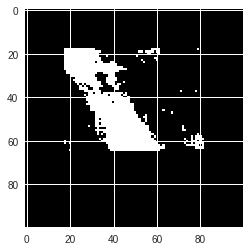

In [84]:
cp = predImg
plt.imshow(cp)

In [0]:
from google.colab import files
from scipy.misc import imsave
#imsave('01_dr_predicted.png', predImg)
#file.SetContentFile('01_dr.JPG_predicted.png')4
files.download('01_dr_predicted.png')

In [29]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL.image

    100% |████████████████████████████████| 5.6MB 5.9MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.1.0
    Uninstalling Pillow-5.1.0:
      Successfully uninstalled Pillow-5.1.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
    100% |████████████████████████████████| 7.1MB 5.1MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.


ModuleNotFoundError: ignored